本文将采用 `Inception V3` 模型实现手语识别，重点是了解 `Inception V3` 模型的结构及其搭建方法。

# 一、前期工作

🔥本文 GitHub [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

- 作者：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- 来自专栏：《深度学习100例》-Tensorflow2版本
- 数据链接：https://pan.baidu.com/s/1YwvN2TSFIHMkrTK64DIlNQ （提取码：qyta）

我的环境：

- 语言环境：Python3.6.5
- 编译器：jupyter notebook
- 深度学习环境：TensorFlow2.4.1

## 1. 设置GPU

如果使用的是CPU可以注释掉这部分的代码。

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]],"GPU")

## 2. 导入数据

In [2]:
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import os,PIL,pathlib

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

from tensorflow import keras
from tensorflow.keras import layers,models

In [3]:
data_dir = "D:/jupyter notebook/DL-100-days/datasets/gestures"

data_dir = pathlib.Path(data_dir)

## 3. 查看数据

In [4]:
image_count = len(list(data_dir.glob('*/*')))

print("图片总数为：",image_count)

图片总数为： 12547


# 二、数据预处理

本文主要是识别24个英文字母的手语姿势（另外两个字母的手语是动作），其中每一个手语姿势图片均有500+张。

## 1. 加载数据

使用`image_dataset_from_directory`方法将磁盘中的数据加载到`tf.data.Dataset`中

In [5]:
batch_size = 8
img_height = 224
img_width = 224

TensorFlow版本是2.2.0的同学可能会遇到`module 'tensorflow.keras.preprocessing' has no attribute 'image_dataset_from_directory'`的报错，升级一下TensorFlow就OK了。

In [6]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 12547 files belonging to 24 classes.
Using 10038 files for training.


In [7]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 12547 files belonging to 24 classes.
Using 2509 files for validation.


我们可以通过class_names输出数据集的标签。标签将按字母顺序对应于目录名称。

In [8]:
class_names = train_ds.class_names
print(class_names)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


## 2. 可视化数据

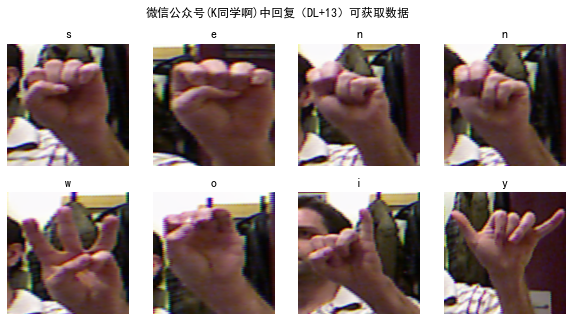

In [9]:
plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("微信公众号(K同学啊)中回复（DL+13）可获取数据")

for images, labels in train_ds.take(1):
    for i in range(8):
        
        ax = plt.subplot(2, 4, i + 1)  

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        
        plt.axis("off")

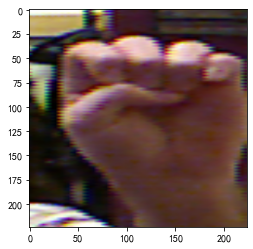

In [10]:
plt.imshow(images[1].numpy().astype("uint8"))

## 3. 再次检查数据 

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(8, 224, 224, 3)
(8,)


- `Image_batch`是形状的张量（8, 224, 224, 3)。这是一批形状240x240x3的8张图片（最后一维指的是彩色通道RGB）。 
- `Label_batch`是形状（8，）的张量，这些标签对应8张图片

## 4. 配置数据集

- **shuffle()** ： 打乱数据，关于此函数的详细介绍可以参考：https://zhuanlan.zhihu.com/p/42417456
- **prefetch()** ：预取数据，加速运行，其详细介绍可以参考我前两篇文章，里面都有讲解。
- **cache()** ：将数据集缓存到内存当中，加速运行

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

如果报错`AttributeError: module 'tensorflow._api.v2.data' has no attribute 'AUTOTUNE'`，可以将`AUTOTUNE=tf.data.AUTOTUNE`更换为`AUTOTUNE = tf.data.experimental.AUTOTUNE`

# 三、Inception V3介绍

关于Inception系列的介绍可以见：https://baike.baidu.com/item/Inception%E7%BB%93%E6%9E%84 ，个人认为这些在现阶段只需要将模型走一遍（学会搭建），后期如果需要的话，可以再回头来进行详细研究。

这个模型相比之前写过的一些模型可能较为复杂一些，先放一张图整体感受一下它

![](pictures/13-1.png)

结构图再来一张，这张更为详细，可点击查看大图

![](pictures/13-2.png)

关于上面卷积的计算还比较蒙的同学可以参考我这篇文章哈：[卷积的计算](https://blog.csdn.net/qq_38251616/article/details/114278995)

# 四、构建Inception V3网络模型

## 1.自己搭建

下面是本文的重点 `Inception V3` 网络模型的构建，可以试着按照上面的图自己构建一下 `Inception V3`，这部分我主要是参考官网的构建过程，将其单独拎了出来。

In [13]:
#=============================================================
#                  Inception V3 网络                          
#=============================================================

from tensorflow.keras.models import Model
from tensorflow.keras        import layers
from tensorflow.keras.layers import Activation,Dense,Input,BatchNormalization,Conv2D,AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D,MaxPooling2D


def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1),name=None):
    
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
        
    x = Conv2D(filters,(num_row, num_col),strides=strides,padding=padding,use_bias=False,name=conv_name)(x)
    x = BatchNormalization(scale=False, name=bn_name)(x)
    x = Activation('relu', name=name)(x)
    return x


def InceptionV3(input_shape=[224,224,3],classes=1000):

    img_input = Input(shape=input_shape)

    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x,  80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #================================#
    #         Block1 35x35
    #================================#
    # Block1 part1
    # 35 x 35 x 192 -> 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],axis=3,name='mixed0')

    # Block1 part2
    # 35 x 35 x 256 -> 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],axis=3,name='mixed1')

    # Block1 part3
    # 35 x 35 x 288 -> 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],axis=3,name='mixed2')

    #================================#
    #          Block2 17x17
    #================================#
    # Block2 part1
    # 35 x 35 x 288 -> 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate([branch3x3, branch3x3dbl, branch_pool], axis=3, name='mixed3')

    # Block2 part2
    # 17 x 17 x 768 -> 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    
    x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],axis=3,name='mixed4')

    # Block2 part3 and part4
    # 17 x 17 x 768 -> 17 x 17 x 768 -> 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],axis=3,name='mixed' + str(5 + i))

    # Block2 part5
    # 17 x 17 x 768 -> 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],axis=3,name='mixed7')

    #================================#
    #         Block3 8x8
    #================================#
    # Block3 part1
    # 17 x 17 x 768 -> 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate([branch3x3, branch7x7x3, branch_pool], axis=3, name='mixed8')

    # Block3 part2 part3
    # 8 x 8 x 1280 -> 8 x 8 x 2048 -> 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate(
            [branch3x3_1, branch3x3_2], axis=3, name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate([branch3x3dbl_1, branch3x3dbl_2], axis=3)

        branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate([branch1x1, branch3x3, branch3x3dbl, branch_pool],axis=3,name='mixed' + str(9 + i))
    
    # 平均池化后全连接。
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    inputs = img_input

    model = Model(inputs, x, name='inception_v3')

    return model

model = InceptionV3()
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## 2.官方模型

In [14]:
# import tensorflow as tf

# model_2 = tf.keras.applications.InceptionV3()
# model_2.summary()

# 五、编译

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：

- 损失函数（loss）：用于衡量模型在训练期间的准确率。
- 优化器（optimizer）：决定模型如何根据其看到的数据和自身的损失函数进行更新。
- 指标（metrics）：用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [15]:
# 设置优化器，我这里改变了学习率。
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 六、训练模型

In [16]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
1255/1255 [==============================] - 146s 77ms/step - loss: 3.9494 - accuracy: 0.3102 - val_loss: 0.6095 - val_accuracy: 0.8481
Epoch 2/10
1255/1255 [==============================] - 70s 56ms/step - loss: 0.7071 - accuracy: 0.8370 - val_loss: 0.1968 - val_accuracy: 0.9430
Epoch 3/10
1255/1255 [==============================] - 70s 56ms/step - loss: 0.2956 - accuracy: 0.9380 - val_loss: 0.0834 - val_accuracy: 0.9757
Epoch 4/10
1255/1255 [==============================] - 70s 56ms/step - loss: 0.1344 - accuracy: 0.9766 - val_loss: 0.0452 - val_accuracy: 0.9884
Epoch 5/10
1255/1255 [==============================] - 71s 57ms/step - loss: 0.0566 - accuracy: 0.9954 - val_loss: 0.0265 - val_accuracy: 0.9916
Epoch 6/10
1255/1255 [==============================] - 72s 57ms/step - loss: 0.0282 - accuracy: 0.9988 - val_loss: 0.0158 - val_accuracy: 0.9956
Epoch 7/10
1255/1255 [==============================] - 72s 57ms/step - loss: 0.0150 - accuracy: 0.9994 - val_loss: 0.0218 

# 七、模型评估

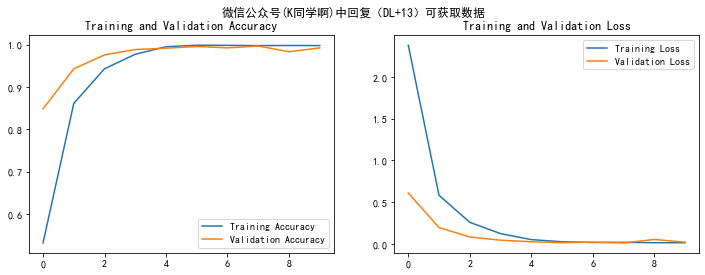

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.suptitle("微信公众号(K同学啊)中回复（DL+13）可获取数据")

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 八、保存and加载模型

这是最简单的模型保存与加载方法哈

In [18]:
# 保存模型
model.save('model/13_model.h5')

In [19]:
# 加载模型
new_model = keras.models.load_model('model/13_model.h5')

# 九、预测

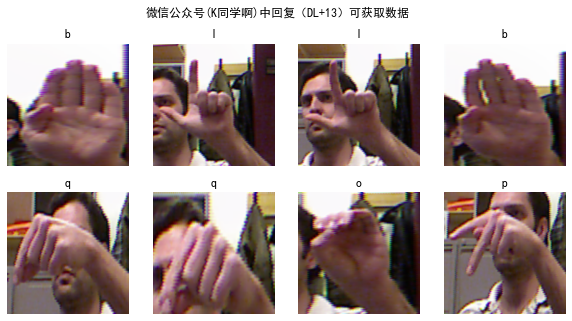

In [20]:
# 采用加载的模型（new_model）来看预测结果

plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("微信公众号(K同学啊)中回复（DL+13）可获取数据")

for images, labels in val_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)  
        
        # 显示图片
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(images[i], 0) 
        
        # 使用模型预测图片中的人物
        predictions = new_model.predict(img_array)
        plt.title(class_names[np.argmax(predictions)])

        plt.axis("off")

***

**推荐阅读**

✨ [**手把手教你用 CNN 识别验证码 - 深度学习100例 | 第12天**](https://mtyjkh.blog.csdn.net/article/details/118152545)

✨ [**卷积神经网络（AlexNet）手把手教学-深度学习100例 | 第11天**](https://mtyjkh.blog.csdn.net/article/details/117986183)

✨ [**循环神经网络（LSTM）实现股票预测-深度学习100例 | 第10天**](https://mtyjkh.blog.csdn.net/article/details/117907074)

✨ [**循环神经网络（RNN）实现股票预测-深度学习100例 | 第9天**](https://mtyjkh.blog.csdn.net/article/details/117752046)

✨ [**深度学习100例-卷积神经网络（CNN）实现mnist手写数字识别 | 第1天**](https://mtyjkh.blog.csdn.net/article/details/116920825) 


**🚀 来自专栏：[《深度学习100例》](https://blog.csdn.net/qq_38251616/category_11068756.html)**

**未完～**

**持续更新 欢迎 点赞👍、收藏⭐、关注👀**

- 点赞👍：点赞给我持续更新的动力
- 收藏⭐️：收藏后你能够随时找到文章
- 关注👀：关注我第一时间接收最新文章